In [1]:
import itertools
import re, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
import random

/tmp/SLURM_361999/ipykernel_2976984/48416997.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=long, x="Bin", y="Signal",


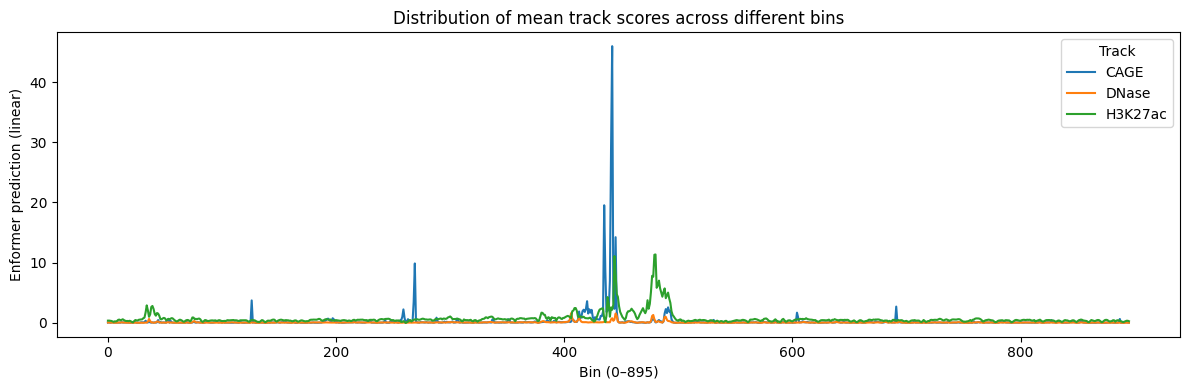

/tmp/SLURM_361999/ipykernel_2976984/48416997.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=long[long.Track==tr], x="Bin", y="Signal",
/tmp/SLURM_361999/ipykernel_2976984/48416997.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=long[long.Track==tr], x="Bin", y="Signal",
/tmp/SLURM_361999/ipykernel_2976984/48416997.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=long[long.Track==tr], x="Bin", y="Signal",


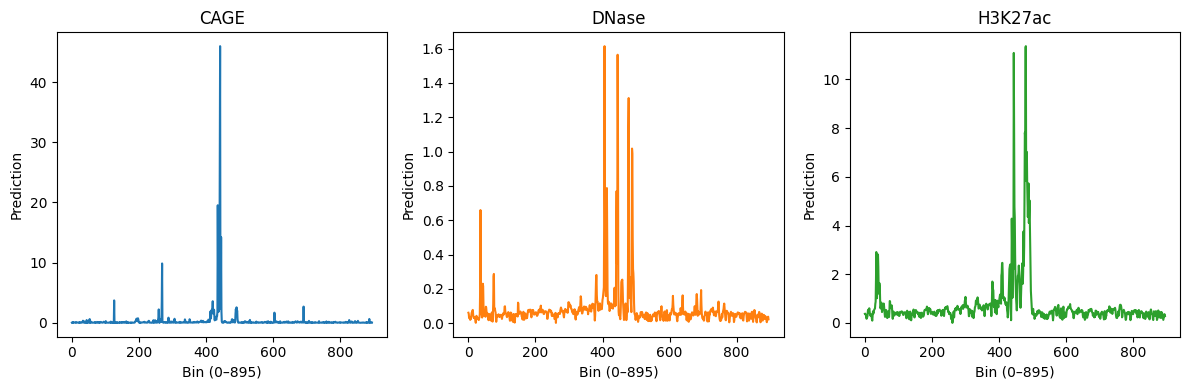

In [8]:
track_cols = ["CAGE", "DNase", "H3K27ac"]
def base(name):          # FOXO_2  ->  FOXO
    return re.sub(r"_\d+$", "", name)

df = pd.read_csv("/home1/saadawy/enformer_upstream/enformer_predictions_unfiltered.tsv", sep="\t")

# 1) average over the 5 shifts  → one row per enhancer/bin
avg_shift = (df
             .groupby(["Enhancer_ID", "Bin"], as_index=False)
             .agg({c: "mean" for c in track_cols}))

# 2) merge isoforms (_1,_2,_3 → base)  → one row per *base* enhancer / bin
avg_shift["Base_ID"] = avg_shift["Enhancer_ID"].map(base)

avg_base = (avg_shift
            .groupby(["Base_ID", "Bin"], as_index=False)
            .agg({c: "mean" for c in track_cols})
            .rename(columns={"Base_ID":"Enhancer_ID"}))

# 3-A)  single axes: mean across base enhancers
long = (avg_base
        .melt(id_vars=["Enhancer_ID", "Bin"],
              value_vars=track_cols,
              var_name="Track", value_name="Signal"))

plt.figure(figsize=(12,4))
sns.lineplot(data=long, x="Bin", y="Signal",
             hue="Track", estimator="mean", ci=None)
plt.title("Distribution of mean track scores across different bins")
plt.xlabel("Bin (0–895)"); plt.ylabel("Enformer prediction (linear)")
plt.tight_layout(); plt.show()

# 3-B)  three separate panels, still mean across enhancers
plt.figure(figsize=(12,4))
for i, tr in enumerate(track_cols):
    ax = plt.subplot(1,3,i+1)
    sns.lineplot(data=long[long.Track==tr], x="Bin", y="Signal",
                 estimator="mean", ci=None, color=f"C{i}")
    ax.set_title(tr)
    ax.set_xlabel("Bin (0–895)")
    ax.set_ylabel("Prediction")
plt.tight_layout(); plt.show()
# PART B  ·  sum bins 444-448  ➜ log2 ➜ averages

df2 = pd.read_csv("/home1/saadawy/enformer_upstream/enformer_predictions_unfiltered.tsv", sep="\t")

mid = df2[df2["Bin"].between(443, 449)].copy() # I chose that range because the TSS is likely in bin 446, so I am centering around that.. I could do 444-448 so that they're 5 bins instead of 7

# -- sum bins 443-449 *per (enhancer, shift)*
summed = (mid
          .groupby(["Enhancer_ID", "Shift"], as_index=False)
          .agg({c: "sum" for c in track_cols}))

# -- log2-transform the sums
for c in track_cols:
    summed[c] = np.log2(summed[c] + 1e-9)   # pseudocount to avoid log2(0)

# -- average over the 5 shifts  (isoforms still separate)
avg_shift = (summed
             .groupby("Enhancer_ID", as_index=False)
             .agg({c: "mean" for c in track_cols}))

# -- merge isoforms (_1,_2,_3 -> base)
final_enhancer_enformer_predictions = (avg_shift
           .assign(Base=avg_shift["Enhancer_ID"].map(base))
           .groupby("Base", as_index=False)
           .agg({c: "mean" for c in track_cols})
           .rename(columns={"Base":"Enhancer_ID"}))

# Select reference enhancer
reference_enhancer = "rd"

# Get logFC values for the reference enhancer
ref_vals = final_enhancer_enformer_predictions.loc[
    final_enhancer_enformer_predictions["Enhancer_ID"] == reference_enhancer,
    track_cols
].iloc[0]

# Subtract reference from all rows to normalize
normalized_df = final_enhancer_enformer_predictions.copy()
for col in track_cols:
    normalized_df[col] = normalized_df[col] - ref_vals[col]

normalized_df.to_csv("normalized_enformer_predictions.tsv", sep="\t", index=False)

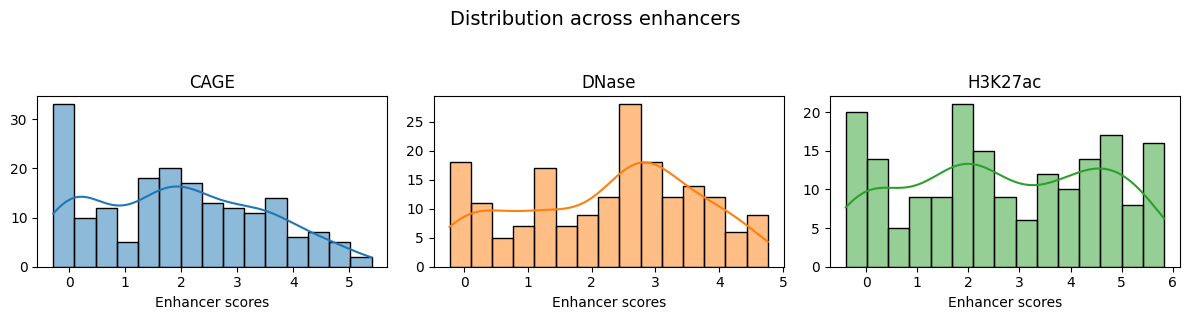

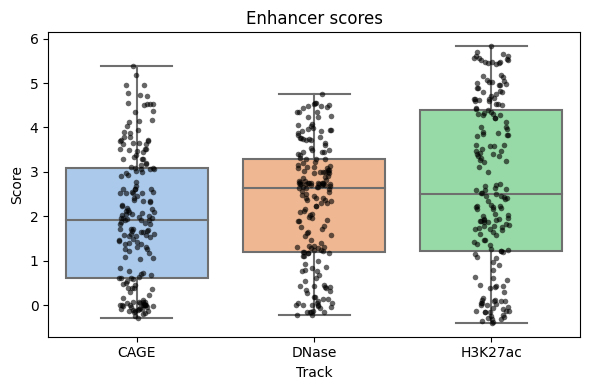

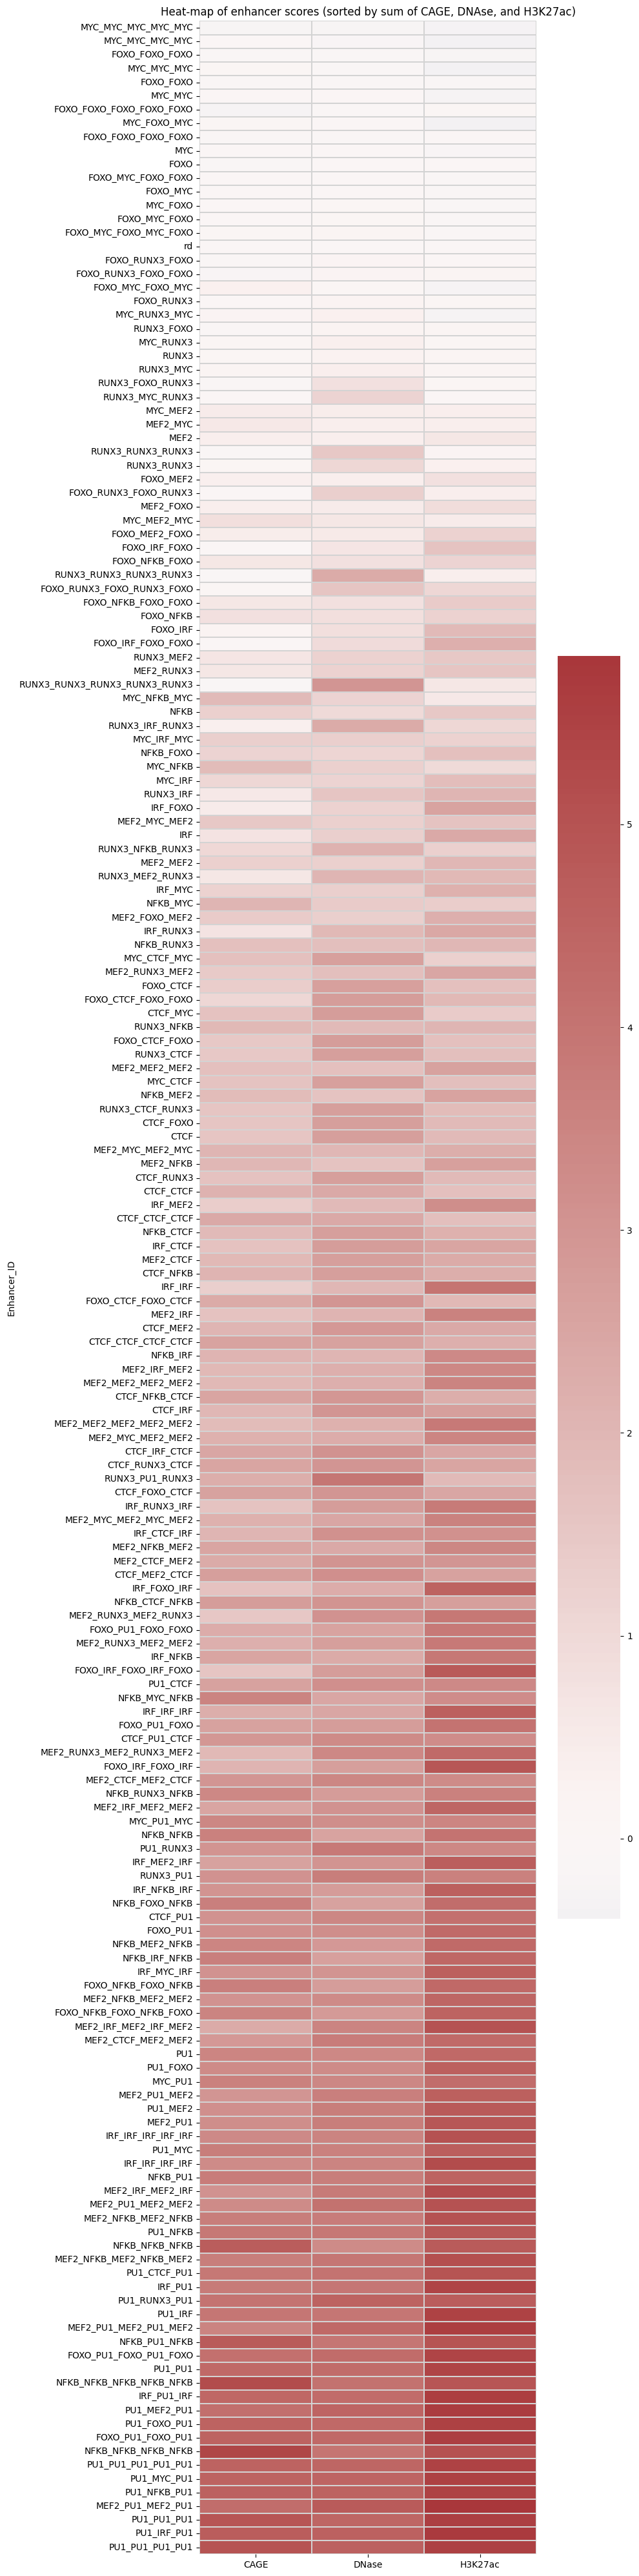

In [9]:
plt.figure(figsize=(12,3))
for i, tr in enumerate(track_cols):
    ax = plt.subplot(1,3,i+1)
    sns.histplot(normalized_df[tr], kde=True, color=f"C{i}", bins=15, edgecolor="k")
    ax.set_title(tr); ax.set_xlabel("Enhancer scores"); ax.set_ylabel("")
plt.suptitle("Distribution across enhancers", y=1.05, fontsize=14)
plt.tight_layout(); plt.show()

long = normalized_df.melt(id_vars="Enhancer_ID", value_vars=track_cols,
                 var_name="Track", value_name="Score")
plt.figure(figsize=(6,4))
sns.boxplot(data=long, x="Track", y="Score", palette="pastel")
sns.stripplot(data=long, x="Track", y="Score", size=4, color="k", alpha=.6)
plt.title("Enhancer scores"); plt.tight_layout(); plt.show()

df_sorted = (normalized_df
             .set_index("Enhancer_ID")
             .assign(Total=lambda d: d["CAGE"] + d["DNase"] + d["H3K27ac"])
             .sort_values("Total", ascending=True))

plt.figure(figsize=(10,40))
sns.heatmap(df_sorted[track_cols],
            cmap="vlag", center=0, annot=False,
            linewidths=.2, linecolor="lightgrey")
plt.title("Heat-map of enhancer scores (sorted by sum of CAGE, DNAse, and H3K27ac)")
plt.tight_layout()
plt.show()

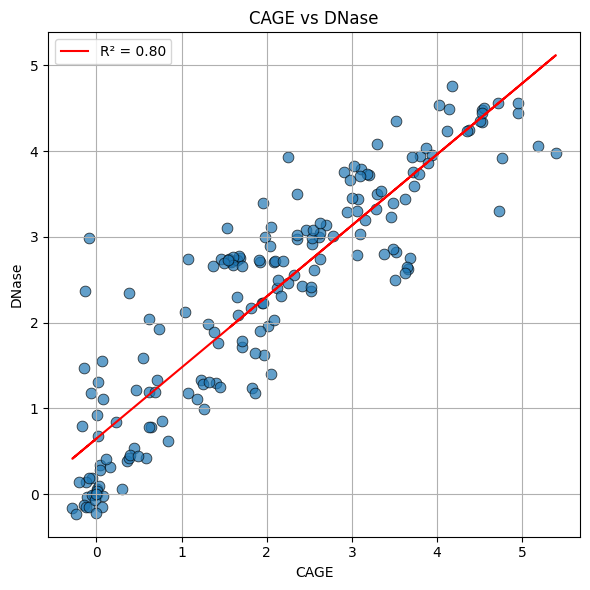

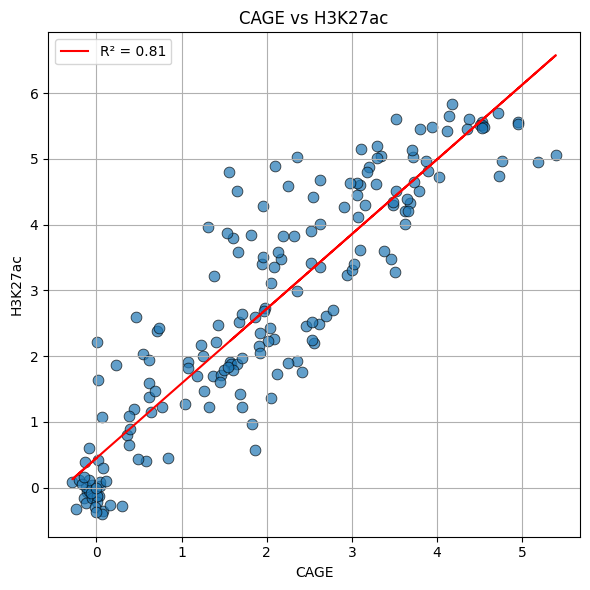

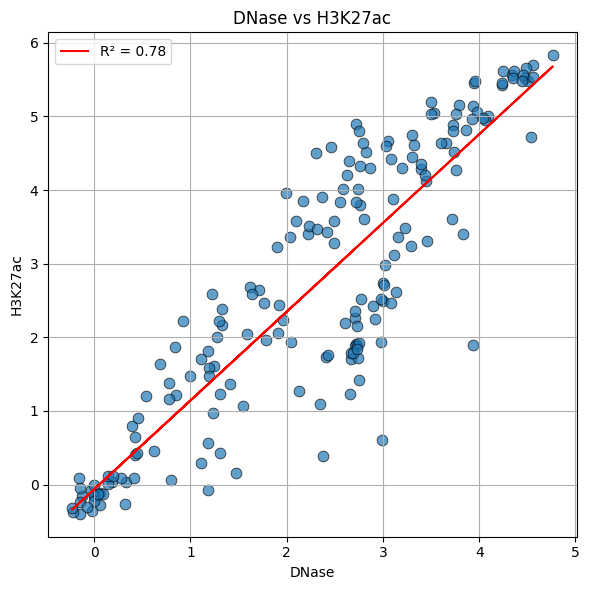

In [10]:
pairs = list(itertools.combinations(track_cols, 2))

for x_col, y_col in pairs:
    x = normalized_df[x_col].values
    y = normalized_df[y_col].values

    slope, intercept = np.polyfit(x, y, 1)
    y_pred = slope * x + intercept

    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=x, y=y, s=60, alpha=0.7, edgecolor='black')
    plt.plot(x, y_pred, color='red', label=f"R² = {r_squared:.2f}")
    plt.title(f"{x_col} vs {y_col}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{x_col,y_col}.png',dpi=600)

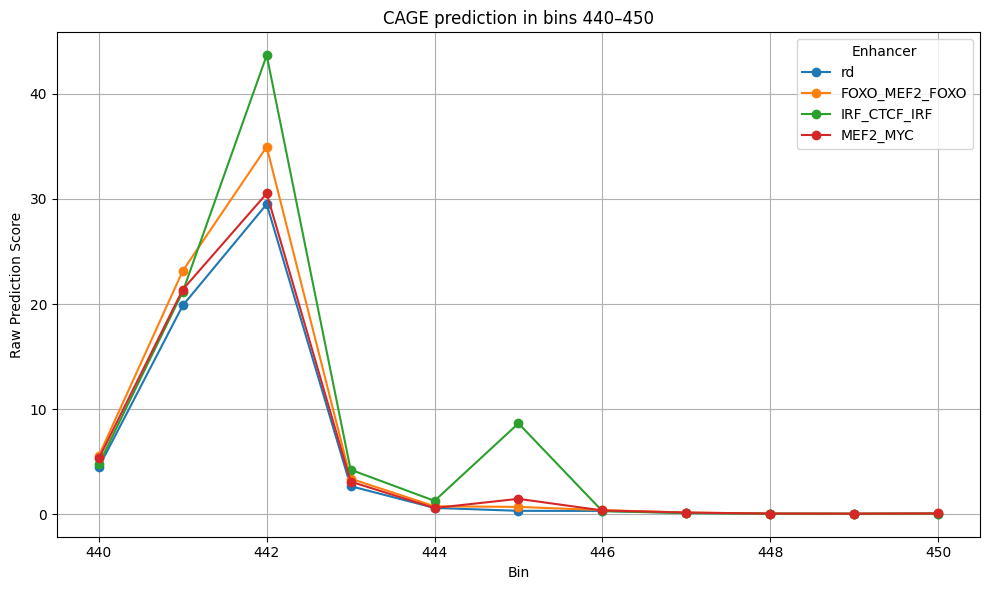

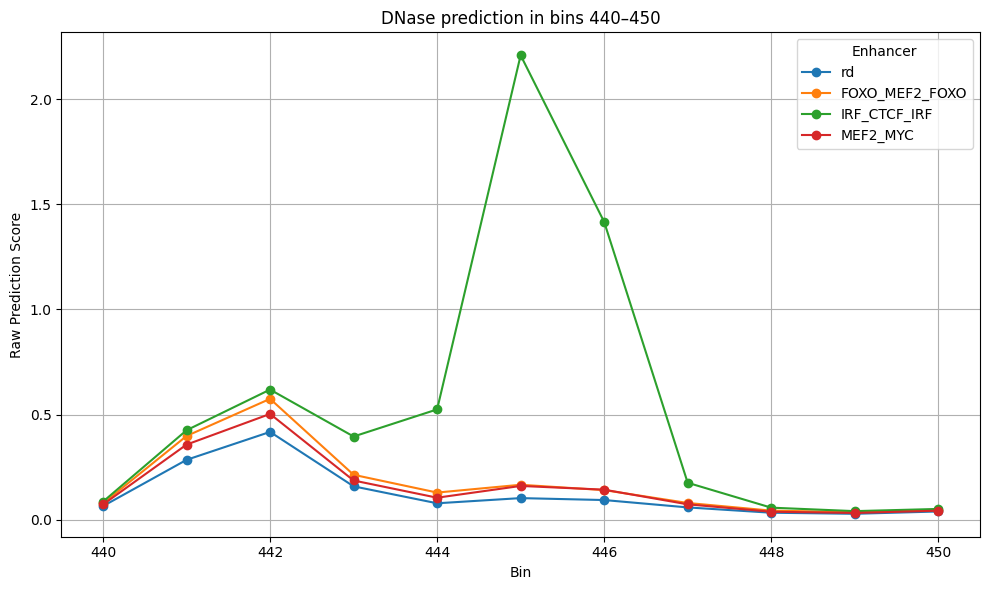

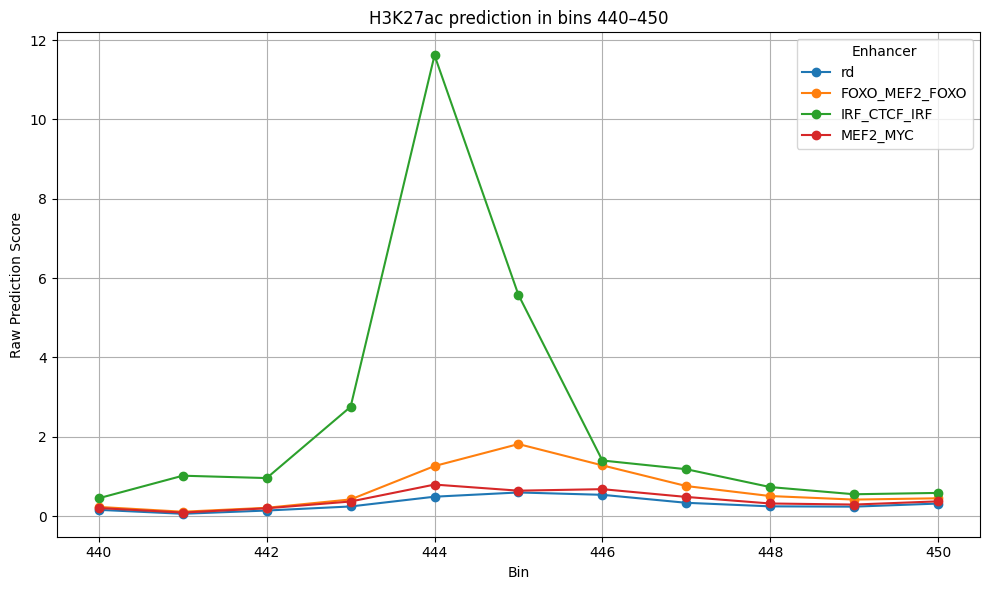

In [11]:
df_shift_avg = df.groupby(["Enhancer_ID", "Bin"], as_index=False).agg({col: "mean" for col in track_cols})

df_shift_avg["Base_ID"] = df_shift_avg["Enhancer_ID"].map(base)
df_base_avg = df_shift_avg.groupby(["Base_ID", "Bin"], as_index=False).agg({col: "mean" for col in track_cols})


focused_bins = df_base_avg[df_base_avg["Bin"].between(440, 450)]

enhancers = focused_bins["Base_ID"].unique().tolist()
enhancers.remove("rd")
chosen = ["rd"] + random.sample(enhancers, 3)

for track in track_cols:
    plt.figure(figsize=(10, 6))
    for enhancer in chosen:
        subset = focused_bins[focused_bins["Base_ID"] == enhancer]
        plt.plot(subset["Bin"], subset[track], label=enhancer, marker='o')

    plt.title(f"{track} prediction in bins 440–450")
    plt.xlabel("Bin")
    plt.ylabel("Raw Prediction Score")
    plt.legend(title="Enhancer")
    plt.grid(True)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{track}.png',dpi=600)

In [12]:
data_path_upstream = '/project2/kribelba_1515/saadawy/mpra/upstream/agg_sum_norm_FALSE_model_indep_groups.csv'
df_upstream = pd.read_csv(data_path_upstream, sep=',', usecols=['logFC', 'SE', 'uid']).rename(columns={'uid': 'Enhancer'})
ref_row = df_upstream[df_upstream["Enhancer"] == "rd"]['logFC'].values[0]
df_upstream['logFC'] = df_upstream['logFC'] - ref_row

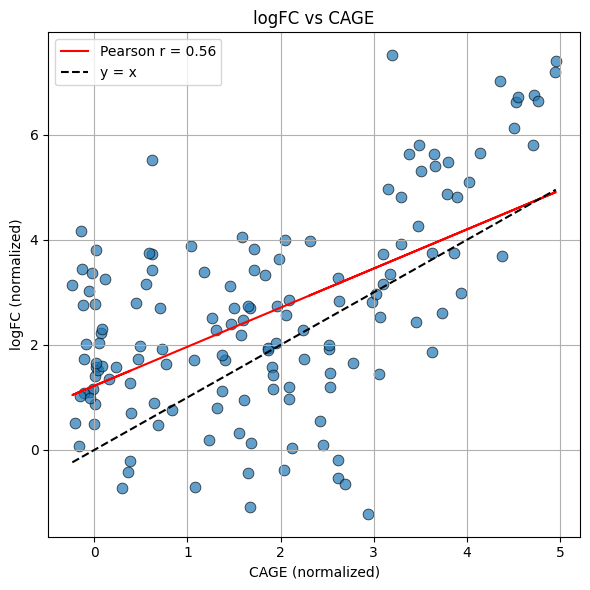

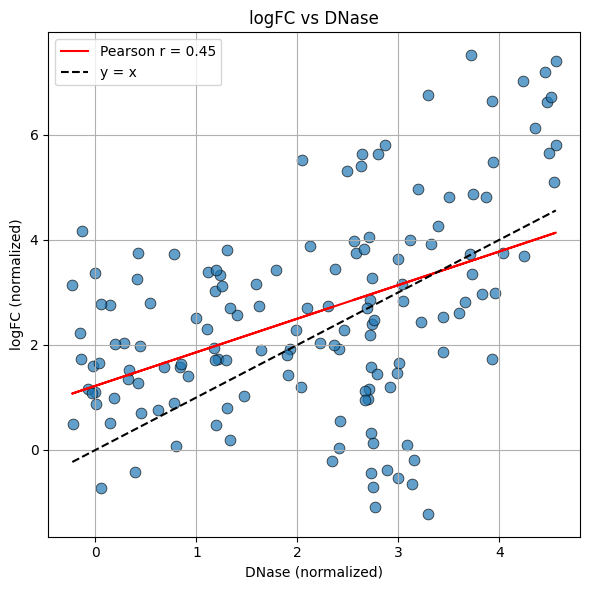

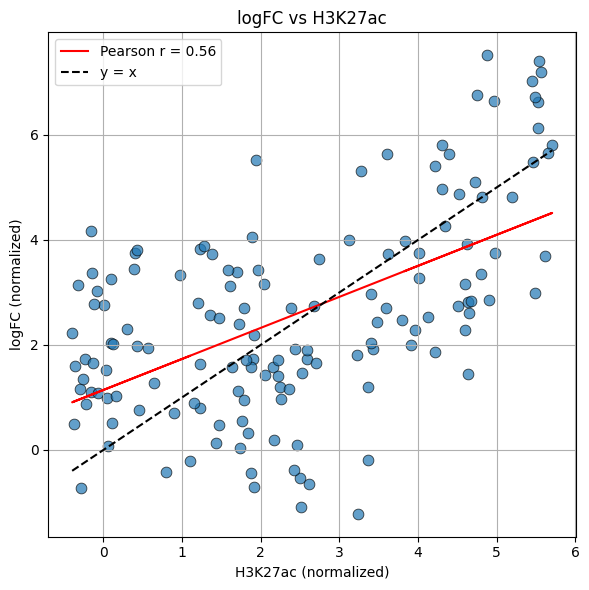

In [13]:
merged = pd.merge(
    df_upstream[["Enhancer", "logFC"]],
    normalized_df[["Enhancer_ID", "CAGE", "DNase", "H3K27ac"]],
    left_on="Enhancer", right_on="Enhancer_ID",
    how='inner'
)

merged.drop(columns=["Enhancer_ID"], inplace=True)

merged_no_rd = merged[merged["Enhancer"] != "rd"].copy()

for track in ["CAGE", "DNase", "H3K27ac"]:
    x = merged_no_rd[track].values
    y = merged_no_rd["logFC"].values

    # Fit line (least squares)
    slope, intercept = np.polyfit(x, y, 1)
    y_pred = slope * x + intercept

    # Pearson correlation
    corr_coef = merged_no_rd[[track, "logFC"]].corr().iloc[0, 1]

    above = np.sum(y > x)
    below = np.sum(y < x)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=x, y=y, s=60, alpha=0.7, edgecolor='black')
    plt.plot(x, y_pred, color='red', label=f"Pearson r = {corr_coef:.2f}")
    plt.plot([min(x), max(x)], [min(x), max(x)], 'k--', label="y = x")

    plt.xlabel(f"{track} (normalized)")
    plt.ylabel("logFC (normalized)")
    plt.title(f"logFC vs {track}")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{track}_against_experimental.png',dpi=600)